# AdaBoost - Introduction

## Boosting

Boosting is a family of ensemble learning techniques. One of its most popular and successful member is XGBoost - Extreme Gradien Boosting, which achives state of the art results in many different tasks, ouperforming even deep learning models (https://arxiv.org/abs/2106.03253).

Boosting as an ensemble method combines serveral base models in order to produce a single predictive model. What distinguish boosting from other families of ensemble methods (e.g. bagging) is the idea of using weak learners as a base models and modyfing learning sample when training successive learners. Weak learner is defined as a classifier that is only slightly better than random guessing. In contrast, a strong learner has sufficiently high accuracy. 

One of the first successful boosting algorithm was AdaBoost, short for Adaptive Boosting. It was primerly applied to classification tasks, but can be easly extended to regression problems. Every data scientist or machine learning engineer should be familer with boosting algoriths, and AdaBoost is a great place to start. In the text we describe the algorithm and implement it by ourself in Python.

## AdaBoost

**AdaBoost** was formulated by Freund and Schapire (1997). AdaBoost produces a sequence of weak classifiers and their predictions are combined to produce the final prediction. The base classifiers have different voting power (weighted vote) as determined by their accuracy. Decision tree with a single node and two leafs is used as a weak learner. This is the simplest possible tree and it's called a **stump**.

[ image of a stump ]

**AdaBoost** modifies training sample by using observation weights. The weights play a crucial role during the training. They indicate observations contribution to a loss function. Therefore observations with larger weights are more influencial and have greater impact on model's parameters. At first, all instances are assigned equal weight. In the successive iterations the observations weights are modified and the classification algorithm is applied on this weighted sample. The weights of misclassified observations are increased, what makes these observations more influencial in the next iteration. On the other hand, the weights are decreased for correctly classified observations. 

**AdaBoost Algorithm**

Mathematically the algorithm can be described as follows.

$\{ ({\bf x_i }, y_i) \}_{i=1}^{N}$ is our training sample, where ${\bf x_i }$ is a vector of $i$-observation features and $y_i$ is a coressponding binary output variable coded as $y_i \in \{-1, 1\}$. There are $N$ observations in the sample. The algorithm produces $M$ weak classifiers $G_m(x)$. The predictions from all of them are then combined through a weighted majority vote:

$$G(x) = sign \left( \sum_{i=1}^{M} \alpha_m G_m(x) \right)$$

1. Initialize the observation weights $w_i = 1/N, i = 1, 2, . . . , N$
2. For m = 1 to M:
    1. Fit a classifier $G_m(x)$ to the training data using weights $w_i$
    2. Computer classifier error 
    $$err_m = \sum_{i=1}^{N} w_i I(y_i \neq G_m(x)_i)$$
    $$I(y_i \neq G_m(x_i)) =
        \begin{cases}
            1 & y_i \ne G_m(x_i) \\
            0 & y_i = G_m(x_i)
        \end{cases}$$
    3. Compute voting power $$\alpha_m = \log \frac{1 - err_m}{err_m} $$
    4. Update weights $$w_i = w_ie^{-\alpha_m y_i G_m(x_i)}, i = 1, 2, ..., N$$
    5. Normalize weights $$w_i = \frac{w_i}{\sum_{i=1}^{N} w_i}, i = 1, 2, ..., N$$
3. Output $$G(x) = sign \left( \sum_{i=1}^{M} \alpha_m G_m(x) \right)$$

### Setup

In [3]:
import numpy as np
import pandas as pd

import sklearn
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons, make_circles
from matplotlib import pyplot as plt

## Utils

In [4]:
def plot_sample(df, model=None, groupby_col = 'y', x='x1', y='x2', label='y', pred='pred',
                colors = {-1:'red', 1:'blue'}, s=100, figsize=(5, 5), h = .02):
    
    fig, ax = plt.subplots(figsize=figsize)
    for key, group in df.groupby(groupby_col):
        group.plot(ax = ax, kind = 'scatter', x = x, y = y, label = key, 
                   color = colors[key], s = s)
        
    if groupby_col == pred:
        df_errors = df[df[label] != df[pred]]
        ax.scatter(df_errors[x], df_errors[y], s=100, linewidths=30, 
                   color=[ colors[row[label]] for index, row in df_errors.iterrows() ], 
                   facecolor=[ colors[row[pred]] for index, row in df_errors.iterrows() ])

    # Contour plot - decision boundary
    if model:
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)    
        ax.contour(xx, yy, Z, 1, colors=('red', 'blue'))

### Sample Data

In [5]:
X, y = make_moons(n_samples = 10, noise = 0.10, random_state=10)
y = np.array([ 1 if item == 0 else -1 for item in y ])

df = pd.DataFrame(dict(x1=X[:,0], x2=X[:,1], y=y))
df = df.round(4)

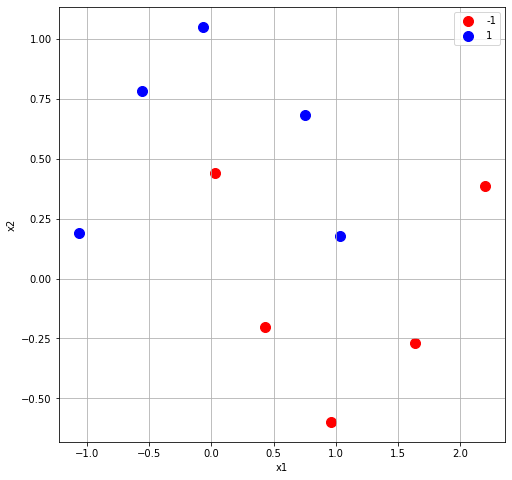

In [86]:
plot_sample(df, figsize=(8, 8))
plt.grid()
plt.savefig('images/sample_01.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

In [7]:
print(df.to_markdown())

|    |      x1 |      x2 |   y |
|---:|--------:|--------:|----:|
|  0 |  1.6407 | -0.2677 |  -1 |
|  1 | -0.0651 |  1.0513 |   1 |
|  2 |  0.0262 |  0.4417 |  -1 |
|  3 |  0.4297 | -0.2018 |  -1 |
|  4 | -0.558  |  0.7827 |   1 |
|  5 |  0.7541 |  0.6837 |   1 |
|  6 |  1.0354 |  0.1784 |   1 |
|  7 |  0.965  | -0.599  |  -1 |
|  8 | -1.0634 |  0.1899 |   1 |
|  9 |  2.1997 |  0.3881 |  -1 |


### AdaBoost (Single Iteration)

#### 1. Initialize the observation weights $w_i = 1/N, i = 1, 2, . . . , N$

The first step is very straightforward. The algorithm initializes the observation weights to $1/N$, where $N$ is a sample size. These weights are going to be modified in successive iterations. Observe that the weights sum to one.

In [8]:
df['weight'] = 1/df.shape[0]

In [9]:
print(df.to_markdown())

|    |      x1 |      x2 |   y |   weight |
|---:|--------:|--------:|----:|---------:|
|  0 |  1.6407 | -0.2677 |  -1 |      0.1 |
|  1 | -0.0651 |  1.0513 |   1 |      0.1 |
|  2 |  0.0262 |  0.4417 |  -1 |      0.1 |
|  3 |  0.4297 | -0.2018 |  -1 |      0.1 |
|  4 | -0.558  |  0.7827 |   1 |      0.1 |
|  5 |  0.7541 |  0.6837 |   1 |      0.1 |
|  6 |  1.0354 |  0.1784 |   1 |      0.1 |
|  7 |  0.965  | -0.599  |  -1 |      0.1 |
|  8 | -1.0634 |  0.1899 |   1 |      0.1 |
|  9 |  2.1997 |  0.3881 |  -1 |      0.1 |


#### 2. For m = 1 to M:

Training loop. $M$ is a hyperparameter indicating number of weak learners. It should be optimized to achive the highest accuracy on a validation sample. One can use also early stopping to avoid overfitting.

#### 2.1. Fit a classifier $G_m(x)$ to the training data using weights $w_i$

In this step we train a classifier on the weighted sample. We use a decision tree with a single node. Other classifiers can be used, but make sure they enable to use weights.

In [10]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(df[['x1', 'x2']], df['y'], sample_weight=df['weight'])

DecisionTreeClassifier(max_depth=1)

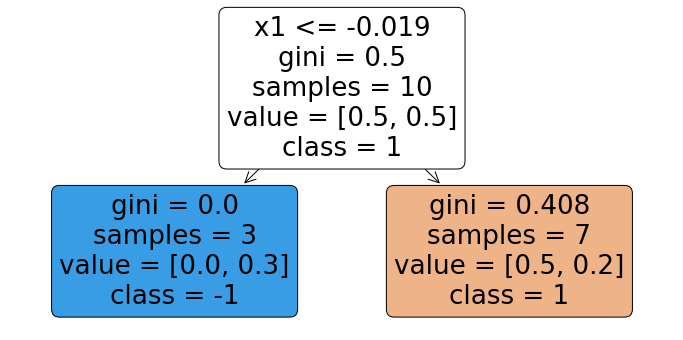

In [11]:
fig = plt.figure(figsize=(12, 6))
_ = sklearn.tree.plot_tree(stump, feature_names=['x1', 'x2'], 
                           class_names=[ '1', '-1' ], filled=True, rounded=True)
plt.savefig('images/stump.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

In [12]:
df['pred'] = stump.predict(df[['x1', 'x2']])

In [13]:
print(df.to_markdown())

|    |      x1 |      x2 |   y |   weight |   pred |
|---:|--------:|--------:|----:|---------:|-------:|
|  0 |  1.6407 | -0.2677 |  -1 |      0.1 |     -1 |
|  1 | -0.0651 |  1.0513 |   1 |      0.1 |      1 |
|  2 |  0.0262 |  0.4417 |  -1 |      0.1 |     -1 |
|  3 |  0.4297 | -0.2018 |  -1 |      0.1 |     -1 |
|  4 | -0.558  |  0.7827 |   1 |      0.1 |      1 |
|  5 |  0.7541 |  0.6837 |   1 |      0.1 |     -1 |
|  6 |  1.0354 |  0.1784 |   1 |      0.1 |     -1 |
|  7 |  0.965  | -0.599  |  -1 |      0.1 |     -1 |
|  8 | -1.0634 |  0.1899 |   1 |      0.1 |      1 |
|  9 |  2.1997 |  0.3881 |  -1 |      0.1 |     -1 |


/home/jagatowski/projects/boosting/venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


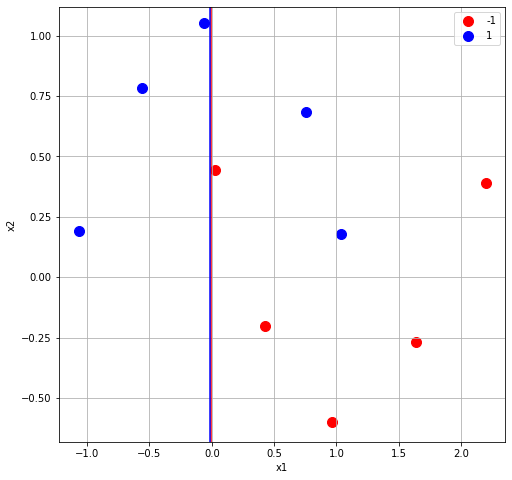

In [87]:
plot_sample(df, model=stump, groupby_col='pred', figsize=(8, 8))
plt.grid()
plt.savefig('images/sample_02.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

#### 2.2. Computer classifier error     

$$err_m = \sum_{i=1}^{N} w_i I(y_i \neq G_m(x)_i)$$

$$I(y_i \neq G_m(x_i)) =
        \begin{cases}
            1 & y_i \ne G_m(x_i) \\
            0 & y_i = G_m(x_i)
        \end{cases}$$

Classification error is calculated by adding weights of missclassified observations.

In [15]:
error = df[df['y'] != df['pred']]['weight'].sum()

print(f'Classification error {error}.')

Classification error 0.2.


#### 2.3. Compute voting power $$\alpha_m = \frac{1}{2} \log \frac{1 - err_m}{err_m}$$

Compute voting power of a classifier. When accuracy/error of a classifier is 50%, then in accordance with the equation voting power is 0. It makes sense considering that accuracy of 50% indicates random guessing. Therefore we should ignore this classifier. If error is lower than 50%, voting power is postivie. The smaller the error, the more classifier will have to say when combining all predictions.

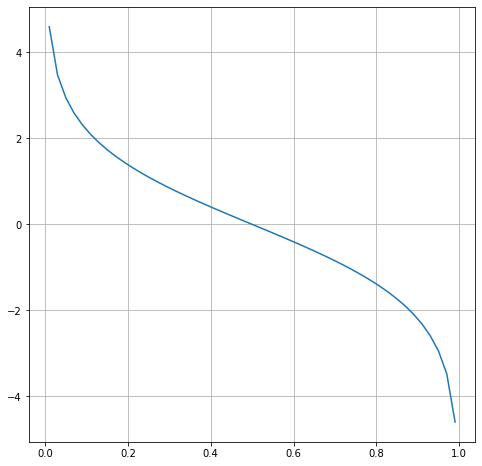

In [16]:
def voting_power(err):
    return np.log((1 - err)/err)

x = np.linspace(0 + 0.01, 1 - 0.01)
y = voting_power(x)

plt.figure(figsize=(8, 8))
plt.grid()
plt.plot(x, y)
plt.savefig('images/clf_weight.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

In [17]:
alpha = 0.5*np.log((1 - error)/error)

##### 2.4. Update weights $$w_i = w_ie^{-\alpha_m y_i G_m(x_i)}, i = 1, 2, ..., N$$

Since $y_i \in \{-1, 1\}$ and $G_m(x_i) \in \{-1, 1\}$, then it follows that their product $y_i G_m(x_i)$ can take only two values: $-1$ and $1$.   When $y_i = G_m(x_i)$, then it equals $1$. Otherwise, in case of misclassification, it equals $-1$. Therefore we can rewrite above expression as:

$$w_i =
        \begin{cases}
            w_i e^{\alpha_m} & y_i \ne G_m(x_i) \\
            w_i e^{-\alpha_m} & y_i = G_m(x_i)
        \end{cases}$$

When updating weights, there are four possible situations.


| Classification | Positive Voting Power ($\alpha_m > 0$)  | Negative Voting Power ($\alpha_m < 0$) |
| ------- | -------- | ----------  |
| **Misclassified $y_i \ne G_m(x_i)$** | Increase   | Decrease     |
| **Correctly classified $y_i = G_m(x_i)$** | Decrease  | Increase       |

E.g. the weights of observations misclassified by a classifier with a positive voting power ($\alpha_m > 0$) will be increased.

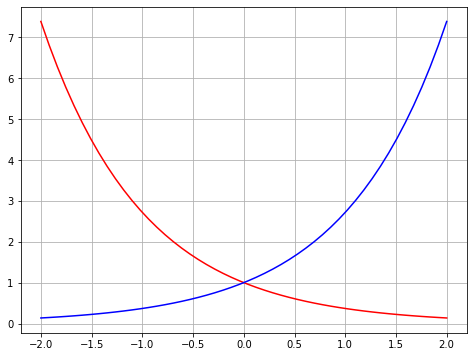

In [18]:
x = np.linspace(-2, 2)

plt.figure(figsize=(8, 6))
plt.grid()
plt.plot(x, np.exp(-x), color='red')
plt.plot(x, np.exp(x), color='blue')
plt.show()

In [19]:
df['weight'] = df['weight']*np.exp(-df['pred']*df['y']*alpha)

In [20]:
print(df.to_markdown())

|    |      x1 |      x2 |   y |   weight |   pred |
|---:|--------:|--------:|----:|---------:|-------:|
|  0 |  1.6407 | -0.2677 |  -1 |     0.05 |     -1 |
|  1 | -0.0651 |  1.0513 |   1 |     0.05 |      1 |
|  2 |  0.0262 |  0.4417 |  -1 |     0.05 |     -1 |
|  3 |  0.4297 | -0.2018 |  -1 |     0.05 |     -1 |
|  4 | -0.558  |  0.7827 |   1 |     0.05 |      1 |
|  5 |  0.7541 |  0.6837 |   1 |     0.2  |     -1 |
|  6 |  1.0354 |  0.1784 |   1 |     0.2  |     -1 |
|  7 |  0.965  | -0.599  |  -1 |     0.05 |     -1 |
|  8 | -1.0634 |  0.1899 |   1 |     0.05 |      1 |
|  9 |  2.1997 |  0.3881 |  -1 |     0.05 |     -1 |


#### 2.5. Normalize weights $$w_i = \frac{w_i}{\sum_{i=1}^{N} w_i}, i = 1, 2, ..., N$$

Normalize weights to make them sum to one. This is the final step of the iteration. New weights are going to be used to train next classifier.

In [21]:
df['weight'].sum()

0.8

In [22]:
df['weight'] = df['weight']/df['weight'].sum()

In [23]:
print(df.to_markdown())

|    |      x1 |      x2 |   y |   weight |   pred |
|---:|--------:|--------:|----:|---------:|-------:|
|  0 |  1.6407 | -0.2677 |  -1 |   0.0625 |     -1 |
|  1 | -0.0651 |  1.0513 |   1 |   0.0625 |      1 |
|  2 |  0.0262 |  0.4417 |  -1 |   0.0625 |     -1 |
|  3 |  0.4297 | -0.2018 |  -1 |   0.0625 |     -1 |
|  4 | -0.558  |  0.7827 |   1 |   0.0625 |      1 |
|  5 |  0.7541 |  0.6837 |   1 |   0.25   |     -1 |
|  6 |  1.0354 |  0.1784 |   1 |   0.25   |     -1 |
|  7 |  0.965  | -0.599  |  -1 |   0.0625 |     -1 |
|  8 | -1.0634 |  0.1899 |   1 |   0.0625 |      1 |
|  9 |  2.1997 |  0.3881 |  -1 |   0.0625 |     -1 |


### AdaBoost (Multiple Iterations)

Let's put together all steps into a loop. Additionaly we need to save all classifiers and their voting power as they are required to make the final prediction.

In [48]:
M = 10

In [49]:
df['weight'] = 1/df.shape[0]

base_models = []
for i in range(M):
    clf = DecisionTreeClassifier(max_depth=1)
    X = df[['x1', 'x2']].to_numpy()
    clf.fit(X, df['y'], sample_weight=df['weight'])
    df['pred'] = clf.predict(X)
    
    error = df[df['y'] != df['pred']]['weight'].sum()
    alpha = 0.5*np.log((1 - error)/error)
    
    df['weight'] = df['weight']*np.exp(-df['pred']*df['y']*alpha)
    df['weight'] = df['weight']/df['weight'].sum()
    
    base_models.append((clf, error, alpha))

In [50]:
def predict(X, base_models):
    preds = [ alpha*clf.predict(X) for clf, error, alpha in base_models ]
    preds = np.stack(preds, axis=1)
    return np.array([1 if x > 0 else -1 for x in preds.sum(axis=1)])

In [51]:
df['pred'] = predict(df[['x1', 'x2']].to_numpy(), base_models)

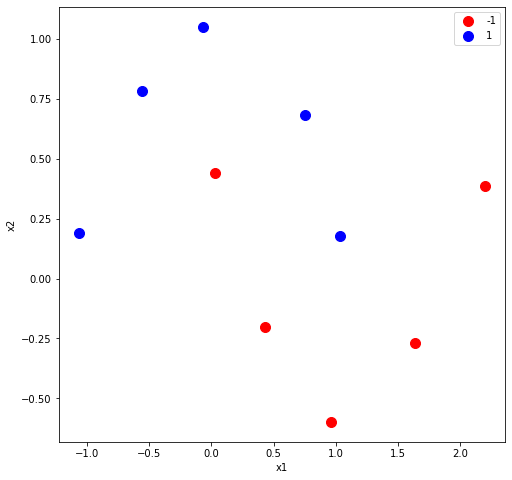

In [60]:
plot_sample(df, groupby_col='pred', figsize=(8, 8))

In [53]:
accuracy_scores = pd.DataFrame([ 
    {
        'n': i,
        'value': accuracy_score(df['y'], predict(df[['x1', 'x2']].to_numpy(), base_models[:i]))
    }
    for i in range(1, len(base_models) + 1)
])

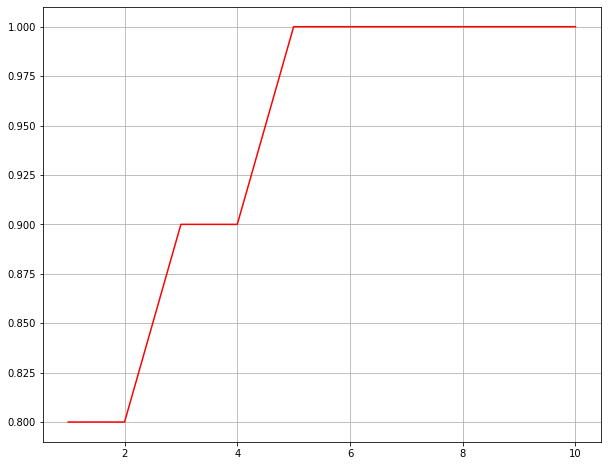

In [54]:
plt.figure(figsize=(10, 8))
plt.grid()
plt.plot(accuracy_scores['n'], accuracy_scores['value'], color='red')
plt.show()

## AdaBoost (Implementation)

In [81]:
class AdaBoostClassifier:
    '''An AdaBoost classifier.'''
    
    def __init__(self, base_classifier, n_classifiers):
        self.base_classifier = base_classifier
        self.n_classifiers = n_classifiers
        self.classifiers = []
        
    def fit(self, X, y):
        '''Build a boosted classifier.'''
        weights = np.full(X.shape[0], 1/X.shape[0])
        for i in range(self.n_classifiers):
            weights = self._fit_classifier(X, y, weights)
            
    def _fit_classifier(self, X, y, weights):
        clf = sklearn.base.clone(self.base_classifier)
        clf.fit(X, y, sample_weight=weights)
        yhat = clf.predict(X)

        error = weights[y != yhat].sum()
        clf_weight = 0.5*np.log((1 - error)/error)

        weights = weights*np.exp(-yhat*y*clf_weight)
        weights = weights/weights.sum()

        self.classifiers.append((clf, clf_weight))
        
        return weights
    
    def predict(self, X):
        '''Predict classes.'''
        preds = [ 
            clf_weight*clf.predict(X) 
            for clf, clf_weight in self.classifiers
        ]
        preds = np.stack(preds, axis=1)
        return np.array([1 if x > 0 else -1 for x in preds.sum(axis=1)])

### Usage

In [127]:
X, y = make_moons(n_samples = 100, noise = 0.20, random_state=10)
y = np.array([ 1 if item == 0 else -1 for item in y ])

df = pd.DataFrame(dict(x1=X[:,0], x2=X[:,1], y=y))

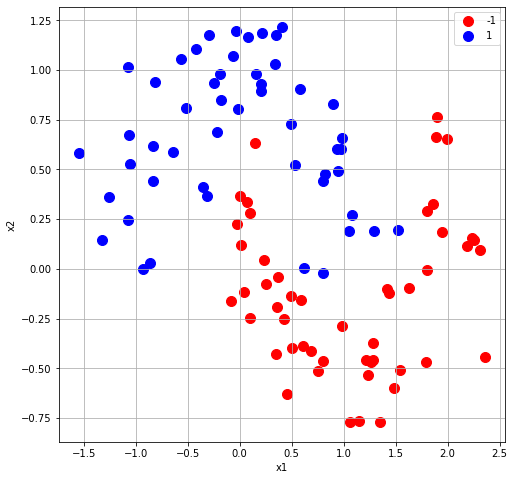

In [130]:
plot_sample(df, groupby_col='y', figsize=(8, 8))
plt.grid()
plt.savefig('images/sample_03.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

In [128]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 50)
ada.fit(df[['x1', 'x2']].to_numpy(), df['y'])

df['pred'] = ada.predict(df[['x1', 'x2']].to_numpy())

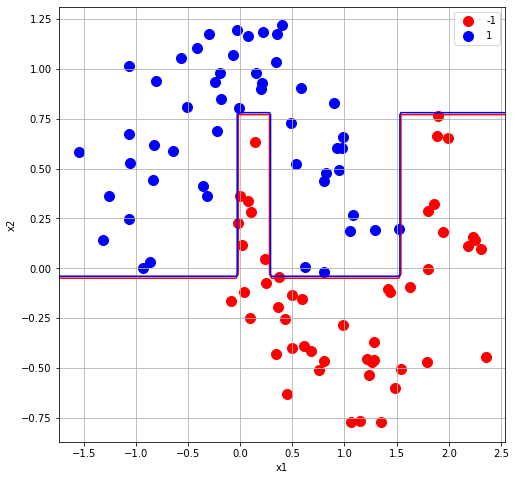

In [131]:
plot_sample(df, model=ada, groupby_col='y', figsize=(8, 8))
plt.grid()
plt.savefig('images/sample_04.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()